# State Space Models

_If you want to understand today, you have to search yesterday_ - Pearl Buck

- Hidden Markov Models
  - Viterbi algorithm 

- Gaussian Mixture Model





In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from finds.readers import fred_qd, fred_md, Alfred
from finds.recipes import approximate_factors, remove_outliers
from secret import paths, credentials
VERBOSE = 0
# %matplotlib qt

In [2]:
# Load and pre-process time series from FRED
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)
vspans = alf.date_spans('USREC')  # to indicate recession periods in the plots

In [3]:
# FRED-MD
freq = 'M'
df, t = fred_md() if freq == 'M' else fred_qd()
transforms = t['transform']
data = pd.concat([alf.transform(df[col], tcode=transforms[col], freq=freq)
                  for col in df.columns],
                 axis=1)\
         .iloc[1:]   # apply transforms and drop first row
cols = list(data.columns)

# remove outliers and impute using Bai-Ng approach
r = 8   # fix number of factors = 8
data = remove_outliers(data)
data = approximate_factors(data, kmax=r, p=0, verbose=VERBOSE)

FRED-MD vintage: monthly/current.csv


In [4]:
# standardize inputs
X = StandardScaler().fit_transform(data.values)

## Hidden Markov Model

In HMM, a multivariate time series is modeled by a system of unobserved (hidden) states that follow a Markov process. There are __transition probabilities__ associated with going from one state to another, or back to itself, represented by a transition matrix $A$. To move from one state to another, we are given information about the previous state and the current __observation__ $X$: an observation is associated with an __emission probability__ for each state $\theta$. Finally we may have prior knowledge of the initial state of the system, that represented by a probability vector $\pi$. Hence a HMM model is defined by the parameters $\lambda = (A, \theta, \pi)$; we observe a sequence of values $X$, which are generated by unobserved state sequence $Z$.

We use the Python package `hmmlearn` to solve the three fundamental tasks:

- Evaluation refers to computing the likelihood of a particular observation, given a model, i.e. what is $P(X | \lambda)$. This problem is solved by the Foward-Backward algorithm, with its `score` method

- Decoding seeks to predict the sequence of hidden states in $Z$ from the sequence of observations $X$, and is solved by a dynamic programming algorithm known as Viterbi algorithm, with the `predict` method.

- Training to learn the model parameters $\lambda = (A, \theta, \pi)$ by maximnizing the likelihood, is solved by by the Baum-Welch algorithm, a special instance of the Expectation-Maximization (EM) algorithm, with the `fit` method

Its `GaussianHMM` model assumes a Gaussian distribution for emissions, where `covariance_type` may be, in increasing order of the number of parameters to be estimated:

- "spherical": each state uses a single variance value that applies to all features
- "diag": each state uses a diagonal covariance matrix.
- "tied": all states use the same full covariance matrix.
- "full": each state uses a full (unrestricted) covariance matrix.

An information criterion such as `bic` can be used to select the best model balancing  the goodness of fit and the number of parameters.


In [5]:
def hmm_summary(markov, X, lengths, matrix=False):
    """Helper to return summary statistics from fitting Hidden Markov Model

    Args:
        markov: Fitted GaussianHMM 
        X: Input data of shape (nsamples, nfeatures)
        lengths: Lengths of the individual sequences in X, sum is nsamples
        matrix: Whether to return the transition and stationary matrices

    Returns:
        Dictionary of results in {'aic', 'bic', 'parameters', 'NLL'}
    """
    logL = markov.score(X, lengths)
    T = np.sum(lengths)      # n_samples
    n = markov.n_features    # number of features ~ dim of covariance matrix
    m = markov.n_components  # number of states
    k = dict(diag=m*n,       # parms in mean and cov matrix
             full=m*n*(n-1)/2,
             tied=n*(n-1)/2,
             spherical=m)[markov.covariance_type] + markov.n_features   
    p = m**2 + (k * m) - 1   # number of indepedent parameters of the model
    
    results = {'aic': -2 * logL + (2 * p),
               'bic': -2 * logL + (p * np.log(T)),
               'parameters': p,
               'NLL' : -logL}
    if matrix:   # whether to return the transition and stationary matrix
        matrix = DataFrame(markov.transmat_)\
            .rename_axis(columns='Transition Matrix:')
        matrix['Stationary'] = markov.get_stationary_distribution()
        results.update({'matrix': matrix})   # return matrix as DataFrame
    return results

In [20]:
# Compare covariance types in Gaussian HMM models 
out = []
for covariance_type in ["full", "diag", "tied", "spherical"]:
    for n_components in range(1, 8):
        if VERBOSE:
            print('=============', covariance_type, n_components, "==========")
        markov = hmm.GaussianHMM(n_components=n_components,
                                 covariance_type=covariance_type,
                                 verbose=VERBOSE,
                                 tol=1e-6,
                                 random_state=42,
                                 n_iter=500)\
                    .fit(X, [X.shape[0]])
        result = hmm_summary(markov, data, [X.shape[0]])
        #print(n_components, Series(results, name=covariance_type).to_frame().T)
        result.update({'cov_type': covariance_type,
                       'n_components': n_components})
        out.append(Series(result))
results = pd.concat(out, axis=1).T.convert_dtypes()

Model is not converging.  Current: -53166.15571297737 is not greater than -53166.155712466214. Delta is -5.111578502692282e-07
Model is not converging.  Current: -6163.604416561489 is not greater than -6163.6044165126905. Delta is -4.8798938223626465e-08
Model is not converging.  Current: 33662.62951552664 is not greater than 34171.8083827127. Delta is -509.17886718605587
Model is not converging.  Current: 38239.33317549184 is not greater than 39427.428995004455. Delta is -1188.095819512615
Model is not converging.  Current: -128529.4491603166 is not greater than -128529.44915884043. Delta is -1.4761608326807618e-06
Model is not converging.  Current: -123452.93136393784 is not greater than -123452.93136010495. Delta is -3.8328871596604586e-06
Model is not converging.  Current: -120079.61301174758 is not greater than -120079.61300834864. Delta is -3.398949047550559e-06
Model is not converging.  Current: -130787.20497186083 is not greater than -130787.2049689297. Delta is -2.931134076789

In [21]:
# Show best bic's
best_bic = []
for covariance_type in ["full", "diag", "tied", "spherical"]:
    result = results[results['cov_type'] == covariance_type]
    argmin = np.argmin(result['bic'])
    best_bic.append(result.iloc[[argmin]])
best_bic = pd.concat(best_bic, axis=0)
best_type = best_bic.iloc[np.argmin(best_bic['bic'])]['cov_type']
print(f"HMM best bic type: {best_type}")
best_bic.round(0)

HMM best bic type: spherical


,aic,bic,parameters,NLL,cov_type,n_components
0,197612200.0,197649489.0,8001,98798099.0,full,1
12,11467703.0,11492530.0,5327,5728524.0,diag,6
14,197612200.0,197649489.0,8001,98798099.0,tied,1
24,7466415.0,7468909.0,535,3732673.0,spherical,4


In [22]:
# fit model with best_bic
n_components = best_bic[best_bic['cov_type'] == best_type]['n_components']
n_components = int(n_components.iloc[0])
markov = hmm.GaussianHMM(n_components=n_components, covariance_type=best_type,
                         verbose=False, tol=1e-6, random_state=0, n_iter=100)\
            .fit(X, [X.shape[0]])
pred_markov = Series(markov.predict(X),
                     name='state',
                     index=pd.to_datetime(data.index, format="%Y%m%d"))
matrix = hmm_summary(markov, X, [X.shape[0]], matrix=True)['matrix']

### Markov Chains

- geometric run
- irreducibility

In [23]:
# Compute average change in INDPRO by state
df = alf('INDPRO', freq=freq, log=1, diff=1)
df.index = pd.DatetimeIndex(df.index.astype(str), freq='infer')
indpro = pd.concat([df, pred_markov], join='inner', axis=1).groupby('state').mean('INDPRO')

# and HMM transition and stationary probabilities
print("HMM states and average INDPRO")
matrix.join(indpro).round(4)

HMM states and average INDPRO


,0,1,2,3,Stationary,INDPRO
0,0.6158,0.0000,0.0000,0.3842,0.0442,-0.0076
1,0.0059,0.8874,0.0196,0.0870,0.2185,0.0010
2,0.0000,0.0081,0.8655,0.1264,0.4647,0.0049
3,0.0576,0.0765,0.2136,0.6523,0.2726,-0.0007


__Plot predicted states__

In [24]:
def plot_states(modelname, labels, num=1, series_id='INDPRO', freq='M'):
    """helper to plot predicted states 'IPMANSICS'"""

    # n_components markers
    n_components = len(np.unique(labels))
    markers = ["o", "s", "d", "X", "P", "8", "H", "*", "x", "+"][:n_components] 
    
    fig, (bx, ax) = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
    fig.suptitle(f"{modelname.upper()} Predicted States")

    # plot series, with states colored
    df = alf(series_id, freq=freq)
    df.index = pd.DatetimeIndex(df.index.astype(str), freq='infer')
    df = df[(df.index >= min(labels.index)) & (df.index <= max(labels.index))]
    for i, marker in zip(range(n_components), markers):
        df.loc[labels == i].plot(ax=ax, style=marker, markersize=2, color=f"C{i}", rot=0)
    ax.set_xlabel(f"{series_id}: {alf.header(series_id)}")
    ax.set_xlim(left=min(df.index), right=max(df.index))
    for a,b in vspans:   # shade economic recession periods
        if (b > min(df.index)) & (a < max(df.index)):
            ax.axvspan(max(a, min(df.index)), min(b, max(df.index)),
                       alpha=0.3, color='grey')
    ax.legend([f"state {i}" for i in range(n_components)], fontsize=8)
    ax.set_yscale('log')

    s = np.zeros((n_components, len(labels)))
    for i, j in enumerate(labels.values.flatten()):
        s[j][i] = j + 1
    sns.heatmap(s, vmin=0, vmax=n_components, ax=bx, cbar=False, xticklabels=False,
                cmap=["lightgrey"] + [f"C{i}" for i in range(n_components)])
    bx.set_xlabel('predicted state')
    plt.tight_layout()

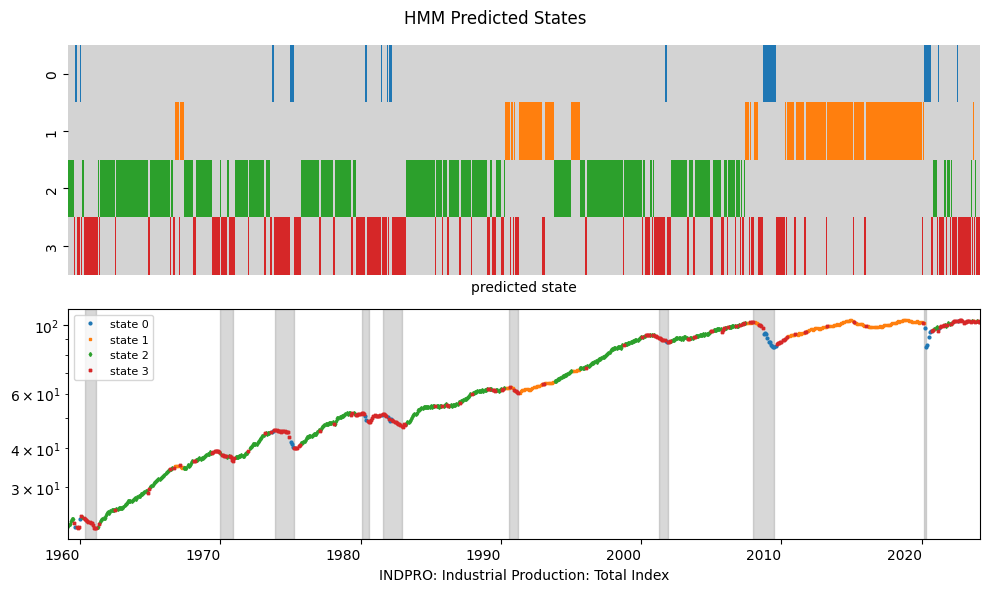

In [25]:
plot_states('HMM', pred_markov, num=1, freq=freq)

## Gaussian Mixture Model


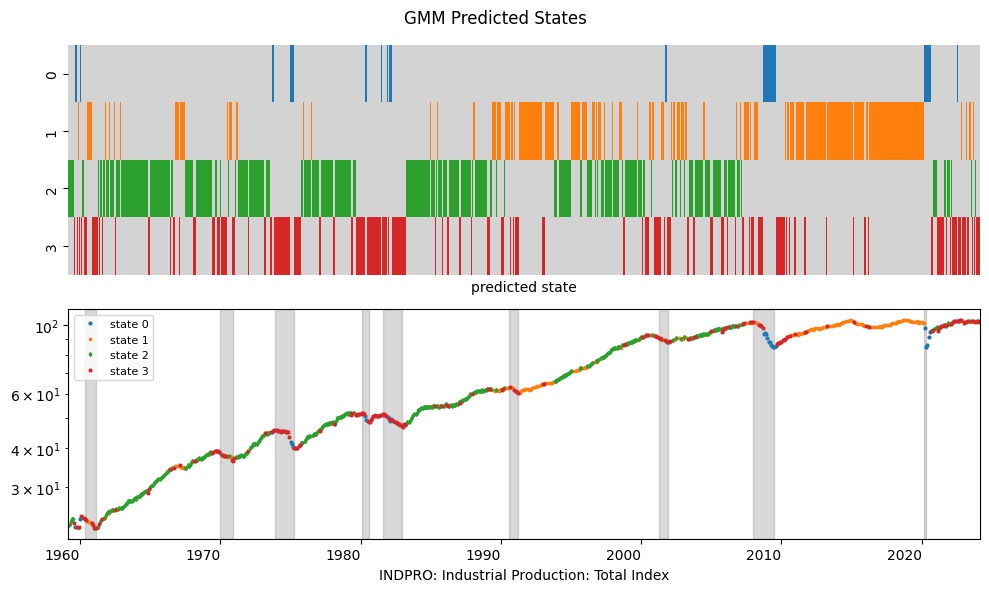

In [26]:
gmm = GaussianMixture(n_components=n_components,
                      random_state=0,
                      covariance_type=best_type).fit(X)
pred_gmm = Series(gmm.predict(X),
                  name='state',
                  index=pd.to_datetime(data.index, format="%Y%m%d"))
plot_states('GMM', pred_gmm, num=2, freq=freq)

In [27]:
# Compare persistance of HMM and GMM
dist = DataFrame({
    'Hidden Markov': ([np.mean(pred_markov[:-1].values == pred_markov[1:].values)]
                      + matrix.iloc[:,-1].tolist()),
    'Gaussian Mixture': ([np.mean(pred_gmm[:-1].values == pred_gmm[1:].values)]
                         + (pred_gmm.value_counts().sort_index()/len(pred_gmm)).tolist())},
                 index=(['Average persistance of states']
                        + [f'Stationary prob of state {s}' for s in range(n_components)]))
print("Compare HMM with GMM:")
dist

Compare HMM with GMM:


,Hidden Markov,Gaussian Mixture
Average persistance of states,0.800000,0.719231
Stationary prob of state 0,0.044240,0.042254
Stationary prob of state 1,0.218489,0.297055
Stationary prob of state 2,0.464711,0.408451
Stationary prob of state 3,0.272560,0.252241


In [28]:
# Visualize HMM transitions and states
from sklearn.preprocessing import minmax_scale
colors = minmax_scale(indpro).flatten()

import graphviz
def fillcolor(r, g, b):
    def scale(x):
        return int((1 - x) * 256 * .5 + 64)
    return f"#{scale(r):02x}{scale(g):02x}{scale(b):02x}"

In [29]:
dot = graphviz.Digraph(engine='circo', graph_attr={'splines': 'true'})
for i in range(len(matrix)):  # Add nodes
    dot.node(name=str(i), label=f"{matrix.iloc[i, i]:.03f}",
             style='filled', fillcolor=fillcolor(0, colors[i], colors[i]))
for i in range(len(matrix)):  # Add edges
    for j in range(len(matrix)):
        if i != j:
            dot.edge(tail_name=str(i), head_name=str(j),
                     label=f"{matrix.iloc[i, j]:.03f}", color='red')


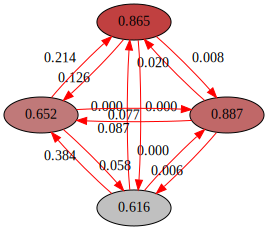

In [30]:
dot
# dot.format = 'png'
# dot.view(filename='digraph')  # Visualize the graph